# AB Testing

Scenario
Imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

H0: p = p0
H1: p =/ p0
alpha: 0.05, confidence level = 95%

In [1]:
#package imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:
- Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
- Alpha value (α) — The critical value we set earlier to 0.05
- Effect size — How big of a difference we expect there to be between the conversion rates

In [5]:
#get effect size

#calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)

#calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1)

#round to next whole #
required_n = ceil(required_n)

print('Need at least {} observations to increase conversion rate from 0.13 to 0.15'.format(required_n))

Need at least 4720 observations to increase conversion rate from 0.13 to 0.15


## Import data

Data: https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv

In [11]:
#path and read csv
path = '/Users/junghopark/Desktop/Python/Ab Testing/0. Data/'
df = pd.read_csv(path+'ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [15]:
#check duplicates

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts>1].count()

print(f'There are {multi_users} users that appear multiple times in dataset')

There are 3894 users that appear multiple times in dataset


Text(0.5, 1.0, 'Number of visits')

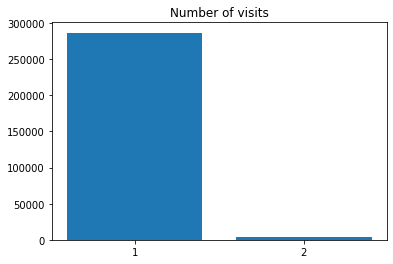

In [64]:
from collections import Counter
x = list(Counter(session_counts).keys())
y = list(Counter(session_counts).values())

plt.bar(x, y, tick_label=x)
plt.title('Number of visits')

## Clean Data

In [67]:
#remove multiple ros
users_to_drop = session_counts[session_counts>1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


## Sampling

In [71]:
control_sample = df[df['group']=='control'].sample(n=required_n, random_state = 42)
treatment_sample = df[df['group']=='treatment'].sample(n=required_n, random_state = 42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
9435,649363,2017-01-13 00:10:17.571044,treatment,new_page,0
9436,868879,2017-01-06 12:21:41.396652,treatment,new_page,0
9437,792022,2017-01-24 03:55:24.551307,treatment,new_page,0
9438,663570,2017-01-04 03:04:33.647683,treatment,new_page,0


## Visualization

In [76]:
conversion_rates = ab_test.groupby('group')['converted']

#stdev of the proportion
std_p = lambda x:np.std(x, ddof=0)
#std error of proportion
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'stdev', 'std_error']

conversion_rates.style.format('{:.3f}')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,conversion_rate,stdev,std_error
group,,,
control,0.115,0.320,0.005
treatment,0.129,0.335,0.005


Text(0, 0.5, 'converted (proportion)')

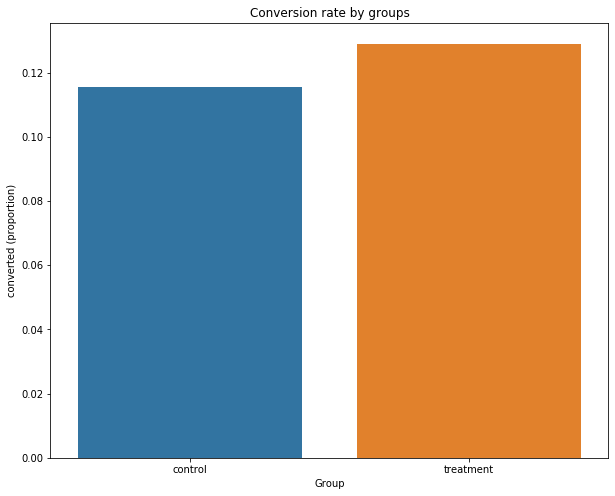

In [77]:
plt.figure(figsize=(10,8))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.title('Conversion rate by groups')
plt.xlabel('Group')
plt.ylabel('converted (proportion)')

Treatment group's value is higher. Is this difference statistically significat?

## Testing the hypothesis

Test hypothesis. Since our sample is large, use normal approxiamation for calculating p-value (z-test)

In [79]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group']=='control']['converted']
treatment_results = ab_test[ab_test['group']=='treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [83]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z stat: {z_stat:.2f}')
print(f'P-value: {pval:.3f}')
print(f'confidence interval 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z stat: -2.01
P-value: 0.044
confidence interval 95% for control group: [0.106, 0.125]
CI 95% interval for treatment group: [0.119, 0.139]


## Conclusion

Since p-val = 0.044 is lower than a=0.05 threshold, we will reject the null hypothesis H0. Which means that our new design did perform significantly different (let alone better) than the old one.

Reject H0: p = p0
H1: p =/ p0

Additionally, the CI for treatment group is 11.9~13.9%.
1. It includes our baseline value of 13% conversion rate.
2. It does not include target value of 15%

This means that it is more likely that the true observation rate of the new design is not similar to our baseline. 
It concludes our foundings to reject the null hypothesis might be a rare instance of random state. Hence, it better to test more on different random state (set as 42).